<a href="https://colab.research.google.com/github/py-projet/CWMR/blob/main/CWMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Marigold/universal-portfolios

In [ ]:
!pip install universal-portfolios

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

import universal as up
from universal import tools, algos
from universal.algos import *

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (12, 7)

<AxesSubplot:>

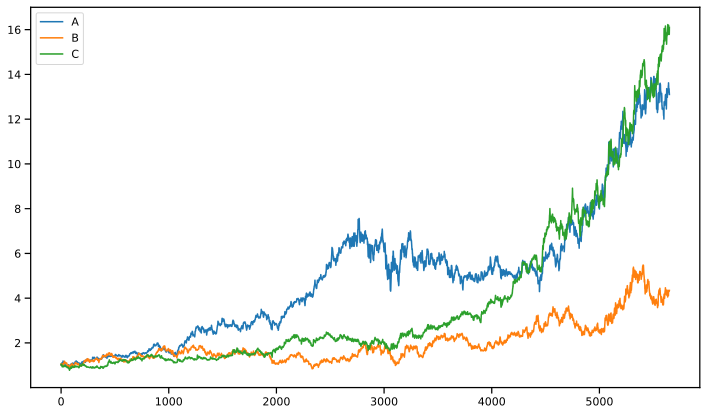

In [ ]:
# load data using tools module
data = tools.dataset('nyse_o')

# plot first three of them as example
data.iloc[:,:3].plot()

# Première exploration

**Confidence weighted mean reversion strategy (cwmr)** modélise le veteur du portefeuille par une distribution gaussienne et met séquentiellement à jour le portefeuille en suivant le principe de retour à la moyenne.

In [ ]:
data = tools.dataset('nyse_o')
algo = algos.CWMR() 
result = algo.run(data)

In [ ]:
#Affichage de quelques statistiques 
print(result.summary())

Summary:
    Profit factor: 1.90
    Sharpe ratio: 3.36 ± 0.54
    Ulcer index: 25.30
    Information ratio (wrt UCRP): 3.28
    UCRP sharpe: 1.16 ± 0.27
    Appraisal ratio (wrt UCRP): 3.15 ± 0.21
    Beta / Alpha: 1.45 / 148.226%
    Annualized return: 170.80%
    Annualized volatility: 50.88%
    Longest drawdown: 211 days
    Max drawdown: 32.79%
    Winning days: 56.8%
    Annual turnover: 437.2
        


Le ratio de Sharpe est superieur à 3 ce qui prouve que la sur-performance ne se fait pas au prix d'un risque trop élevé. Alors l'allocation est parfaite.

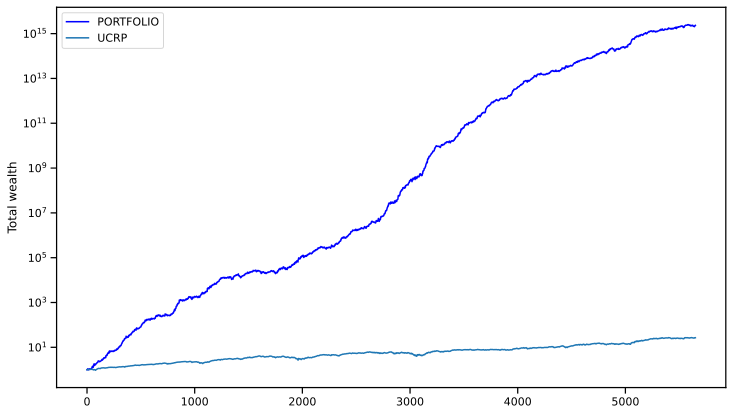

In [ ]:
result.plot(weights=False, assets=False, ucrp=True, logy=True);

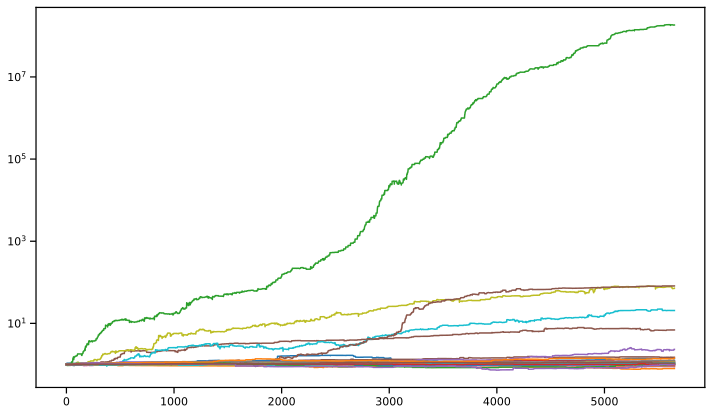

In [ ]:
result.plot_decomposition(legend=False, logy=True);

La performance dépend surtout des 5 premiers actifs comme le montre le graphe ci-dessus.

# **Deuxième exploration**

In [ ]:
from pandas_datareader.data import DataReader

# Télechargement des données depuis yahoo
yahoo_data = DataReader(['AMZN' ,'IBM', 'AAPL', 'GOOG'], 'yahoo', start=dt.datetime(2017,1,1))['Adj Close']

In [ ]:
yahoo_data.head()

Symbols,AMZN,IBM,AAPL,GOOG
Date,,,,
2017-01-03,37.683498,124.062180,27.257639,786.140015
2017-01-04,37.859001,125.598190,27.227139,786.900024
2017-01-05,39.022499,125.182655,27.365597,794.020020
2017-01-06,39.799500,125.798515,27.670671,806.150024
2017-01-09,39.846001,124.403519,27.924124,806.650024


In [ ]:
#Ce qu'on peut gagner en moyenne en pourcentage
yahoo_data.pct_change().mean()

Symbols
AMZN    0.000980
IBM     0.000230
AAPL    0.001369
GOOG    0.000896
dtype: float64

**Optimisation d'un portefeuille aléatoire** : Dans cette partie et en s'aidant d'internet, j'optimiserais un portefeuille aléatoire dans le but de comparer avec le ratio de sharpe déjà obtenu pour le portefeuille avec CWMR

In [ ]:
import numpy as np
num_ports = 1500
log_ret = np.log(yahoo_data/yahoo_data.shift(1)) 
all_weights = np.zeros((num_ports,len(yahoo_data.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for p in range(num_ports):

    # Créer des poids aléatoires
    weights = np.array(np.random.random(4))

    # Pondération des poids
    weights = weights / np.sum(weights)
    
    # Sauvegarde des Poids
    all_weights[p,:] = weights

    # rendement attendu
    ret_arr[p] = np.sum((log_ret.mean() * weights) *252)

    # variance Attendue
    vol_arr[p] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Ratio de Sharpe
    sharpe_arr[p] = ret_arr[p]/vol_arr[p]

**Optimisation**

In [ ]:
from scipy.optimize import minimize

In [ ]:
def get_value(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])


In [ ]:
def nsharpe(weights):
    return  get_value(weights)[2] * -1

In [ ]:
def check_sum(weights):
    return np.sum(weights) - 1

In [ ]:
cons = ({'type':'eq','fun': check_sum})
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
init_guess = [0.25,0.25,0.25,0.25]


In [ ]:
opt_results = minimize(nsharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [ ]:
get_value(opt_results.x)

array([0.29492038, 0.30830113, 0.95659845])

Même après optimisation le ratio de Sharpe pour CWMR reste le meilleur.

# **Troisième exploration**

In [ ]:
mS = yahoo_data.resample('M').last()
wS = yahoo_data.resample('W').last()

/usr/local/lib/python3.7/dist-packages/universal/algos/cwmr.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  (-b + sqrt(b ** 2 - 4 * a * c)) / (2.0 * a),
/usr/local/lib/python3.7/dist-packages/universal/algos/cwmr.py:87: RuntimeWarning: invalid value encountered in double_scalars
  (-b - sqrt(b ** 2 - 4 * a * c)) / (2.0 * a),


Summary:
    Profit factor: 1.37
    Sharpe ratio: 0.96 ± 0.52
    Ulcer index: 2.63
    Information ratio (wrt UCRP): 0.38
    UCRP sharpe: 0.99 ± 0.52
    Appraisal ratio (wrt UCRP): 0.29 ± 0.43
    Beta / Alpha: 1.08 / 5.188%
    Annualized return: 27.55%
    Annualized volatility: 28.73%
    Longest drawdown: 361 days
    Max drawdown: 35.29%
    Winning days: 56.5%
    Annual turnover: 76.4
        


/usr/local/lib/python3.7/dist-packages/universal/result.py:415: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if B.drop(["CASH"], 1, errors="ignore").values.min() < -0.01:
/usr/local/lib/python3.7/dist-packages/universal/result.py:424: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  B = B.drop("CASH", 1, errors="ignore")


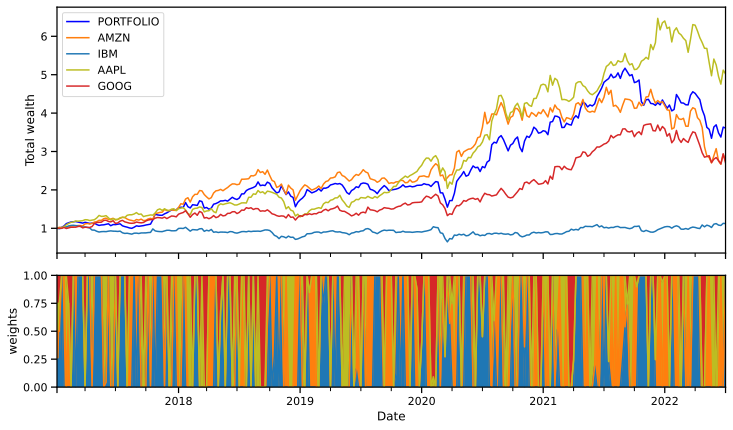

In [ ]:
result3 = algo.run(wS)
print(result3.summary())
result3.plot();
#On remarquera qu'il y a une forte fluctuation des poids

**Le drawdown** : Le drawdown est une mesure du risque de la stratégie. Une statistique intéressante pour connaître la performance de l'algorithme est le maximum drawdown. En effet, il représente la perte maximale d'une stratégie sur une période de temps qui vous permet de comprendre si la stratégie est risquée et donc de la choisir en fonction de votre niveau d'aversion au risque.

In [ ]:
result3.max_drawdown

0.3529246695599233

In [ ]:
result3.drawdown_period

361.2028065486134

In [ ]:
algo = CRP()
result4 = algo.run(wS)
print(result4.max_drawdown)
print(result4.drawdown_period)

0.2736230469610853
221.53772134981622


In [ ]:
algo = PAMR()
result6 = algo.run(wS)
print(result6.max_drawdown)
print(result6.drawdown_period)

/usr/local/lib/python3.7/dist-packages/universal/algos/pamr.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  lam = le / np.linalg.norm(x - x_mean) ** 2


0.35516693357684026
361.2028065486134


In [ ]:
algo = RMR()
result5 = algo.run(wS)
print(result5.max_drawdown)
print(result5.drawdown_period)

0.3378982989204812
356.38676912796524


CRP s'avère offrant le meilleur compromis entre valeur maximum et période de drawdown. 
CWMR reste l'algorithme qui prend une période asses longue ( entre les trois algorithmes alloués ) avec un risque aussi élevé .